# Formulary status

The formulary status of a drug on an insurance plan can be reflected by its rejection rate and associated copayment. Generally, if a drug is covered by the insurance plan, the copayment is lower after the deductible is meet. The prefered drug on the formulary usually has a low price estimated by the copayment before the deductible is meet and a low, if not zero, rejection rate.

## 1. Rejection rates

The rejection rate of a drug on an insurance plan can be estimated from the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [2]:
#import data
df_original = pd.read_csv('pharmacy_tx.csv')
df = df_original.copy()

In [3]:
# the insurance plan is uniquely determined by bin, pcn and group
# missing data in pcn and group are treated as not required and form a class within the category
df['bin'] = df['bin'].astype(str)
df['pcn'] = df['pcn'].astype(str).str.upper()
df['group'] = df['group'].astype(str).str.upper()
df['rejected'][df['rejected'] == False] = 0
df['rejected'][df['rejected'] == True] = 1

<ipython-input-3-3af655975e22>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rejected'][df['rejected'] == False] = 0


In [4]:
# get rejection rates
formula = df.groupby(['bin', 'pcn', 'group', 'drug']).rejected.mean().to_frame()
formula.columns = ['rejection_rate']
formula

rejection_rate
bin    pcn     group    drug                                   
160389 RB7UU   RS5RB3YA branded antimab                0.000000
                        branded bovirol                0.000000
                        branded brede                  0.208267
                        branded choxestamenium         0.322488
                        branded cibroniudosin          0.000000
...                                                         ...
96934  S76J7V6 NAN      generic tanoclolol             0.000000
                        generic thiostasteglume        0.000000
                        generic todiadianic            0.000000
                        generic tovane                 0.000000
                        generic vocopirin              0.000000

[7087 rows x 1 columns]

## 2. Copayments and formulary status

In [5]:
# copayment is 0 if the claim is rejected
print(pd.unique(df[df['rejected'] == 1]['patient_pay']))
print(pd.unique(df[df['patient_pay'] == 0]['rejected']))

[0.]
[1.]


As shown above, the copayment is always 0 if the claim is rejected, which means the patient refuses to pay anything if the claim is rejected. As a result, zero copayment should be excluded from the data for getting copayments.

In [6]:
# excluding zero copayment
# only approved claims in data present no need for 'rejected' column
df = df[df['rejected'] == 0].drop(columns = ['rejected'])

For a drug on an insurance plan in a pharmacy, there is either one copayment or two copayments.

In [7]:
# confirm only one or two copayments for a drug on an insurance plan in a pharmacy
df_pharmacy = df[['bin', 'pcn', 'group', 'drug', 'pharmacy', 'patient_pay']]
df_pharmacy_groups = df_pharmacy.groupby(['bin', 'pcn', 'group', 'drug', 'pharmacy'])
copayment_uniques = set(len(pd.unique(group['patient_pay'])) for name, group in df_pharmacy_groups)
copayment_uniques

{1, 2}

<ipython-input-8-809c3f468ad5>:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


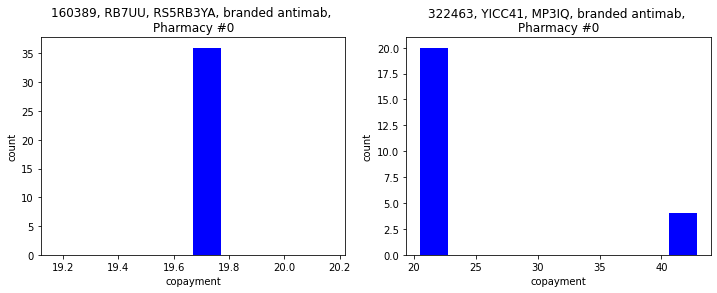

In [8]:
# plotting two typical distributions of a drug on an insurance plan in a pharmacy
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# branded antimab on the insurance ('160389', 'RB7UU', 'RS5RB3YA') in Pharmacy #0 has one copayment
axs[0].hist(df_pharmacy_groups.get_group(('160389', 'RB7UU', 'RS5RB3YA', 'branded antimab', 'Pharmacy #0'))['patient_pay'], 
            color = 'b')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('count')
axs[0].set_title('160389, RB7UU, RS5RB3YA, branded antimab, \nPharmacy #0')

# branded antimab on the insurance ('322463', 'YICC41', 'MP3IQ') in Pharmacy #0 has two copayments
axs[1].hist(df_pharmacy_groups.get_group(('322463', 'YICC41', 'MP3IQ', 'branded antimab', 'Pharmacy #0'))['patient_pay'], 
            color = 'b')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('count')
axs[1].set_title('322463, YICC41, MP3IQ, branded antimab, \nPharmacy #0')

fig.show()

The copayments for the drug on an insurance plan can be obtained as following. If a drug on an insurance plan has one copayment in all the pharmacies, a Gaussian mixture model with one component is fitted to extract the mean for copayment and the standard deviation for fluctuation. If a drug on an insurance plan has two copayment in any pharmacy, a Gaussian mixture model with two components is fitted to extract two means for high copayment and low copayment and two standard deviations for fluctuations around them.

In [9]:
# getting drugs having two copayments on an insurance plan
two_copayments = set(name[:4] for name, group in df_pharmacy_groups if len(pd.unique(group['patient_pay'])) == 2)

In [10]:
# getting all the drugs on all the insurance plans
df_drug = df[['bin', 'pcn', 'group', 'drug', 'patient_pay']]
df_drug_groups = df_drug.groupby(['bin', 'pcn', 'group', 'drug'])

In [11]:
# importing Gaussian mixture model
from sklearn.mixture import GaussianMixture

# fitting model and updating formula
for name, group in df_drug_groups:
    if name in two_copayments:
        gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
        gm.fit(group['patient_pay'].to_numpy().reshape(-1, 1))
        means = np.round(gm.means_.ravel(), 2)
        stds = np.round(np.sqrt(gm.covariances_.ravel()), 2)
        if means[0] > means[1]:
            formula.loc[name, 'copayment_high'] = means[0]
            formula.loc[name, 'std_high'] = stds[0]
            formula.loc[name, 'copayment_low'] = means[1]
            formula.loc[name, 'std_low'] = stds[1]
        else:
            formula.loc[name, 'copayment_high'] = means[1]
            formula.loc[name, 'std_high'] = stds[1]
            formula.loc[name, 'copayment_low'] = means[0]
            formula.loc[name, 'std_low'] = stds[0]
    else:
        try:
            gm = GaussianMixture(n_components = 1, init_params = 'k-means++', random_state = 614)
            gm.fit(group['patient_pay'].to_numpy().reshape(-1, 1))
            formula.loc[name, 'copayment_high'] = np.round(gm.means_.ravel(), 2)[0]
            formula.loc[name, 'std_high'] = np.round(np.sqrt(gm.covariances_.ravel()), 2)[0]
        except:
            formula.loc[name, 'copayment_high'] = group['patient_pay'].to_numpy()[0]
            formula.loc[name, 'std_high'] = 0
        formula.loc[name, 'copayment_low'] = formula.loc[name, 'copayment_high']
        formula.loc[name, 'std_low'] = formula.loc[name, 'std_high']

The distribution of the ratio of extracted standard deviation to extracted mean is well concentrated around 0, which confirms copayments only has small fluctuations and Gaussian is a suitable model.

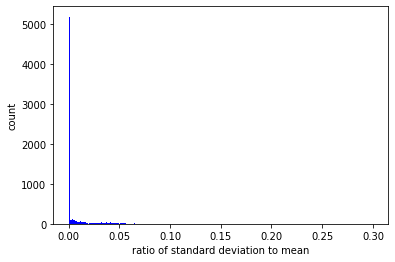

In [38]:
# confirm Gaussian mixture is a suitable model
bins = np.linspace(0, 0.3, 300)
plt.hist(formula['std_high'] / formula['copayment_high'], bins, color = 'b')
plt.xlabel('ratio of standard deviation to mean')
plt.ylabel('count')
plt.show()
plt.close()

In [12]:
formula

rejection_rate  \
bin    pcn     group    drug                                      
160389 RB7UU   RS5RB3YA branded antimab                0.000000   
                        branded bovirol                0.000000   
                        branded brede                  0.208267   
                        branded choxestamenium         0.322488   
                        branded cibroniudosin          0.000000   
...                                                         ...   
96934  S76J7V6 NAN      generic tanoclolol             0.000000   
                        generic thiostasteglume        0.000000   
                        generic todiadianic            0.000000   
                        generic tovane                 0.000000   
                        generic vocopirin              0.000000   

                                                 copayment_high  std_high  \
bin    pcn     group    drug                                                
160389 RB7UU   RS5RB3YA branded antimab                   20.63      0.73   
                        branded bovirol                   12.54      0.00   
                        branded brede                     18.71      0.73   
                        branded choxestamenium           132.07      0.72   
                        branded cibroniudosin             12.54      0.00   
...                                                         ...       ...   
96934  S76J7V6 NAN      generic tanoclolol                 6.17      0.00   
                        generic thiostasteglume           23.95      0.00   
                        generic todiadianic               63.25      0.00   
                        generic tovane                     9.38      0.00   
                        generic vocopirin                 17.35      0.00   

                                                 copayment_low  std_low  
bin    pcn     group    drug                                             
160389 RB7UU   RS5RB3YA branded antimab                  20.63     0.73  
                        branded bovirol                  12.54     0.00  
                        branded brede                    18.71     0.73  
                        branded choxestamenium          132.07     0.72  
                        branded cibroniudosin            12.54     0.00  
...                                                        ...      ...  
96934  S76J7V6 NAN      generic tanoclolol                6.17     0.00  
                        generic thiostasteglume          15.57     0.74  
                        generic todiadianic              29.09     0.69  
                        generic tovane                    9.38     0.00  
                        generic vocopirin                13.28     0.77  

[7087 rows x 5 columns]

Now that the copayment for each drug on each insurance plan has been identified, if two copayments are identified, the difference between the two copayments can be interpreted as the coverage by the insurance after the deductible is meet. The copayment differences for all the drugs on each insurance plan are plotted against the higher copayments below with color set by the rejection rate.

In [39]:
# getting copayments
copayments = formula.copy().reset_index()
copayments_groups = copayments.groupby(['bin', 'pcn', 'group'])

<ipython-input-40-36108b7e8681>:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


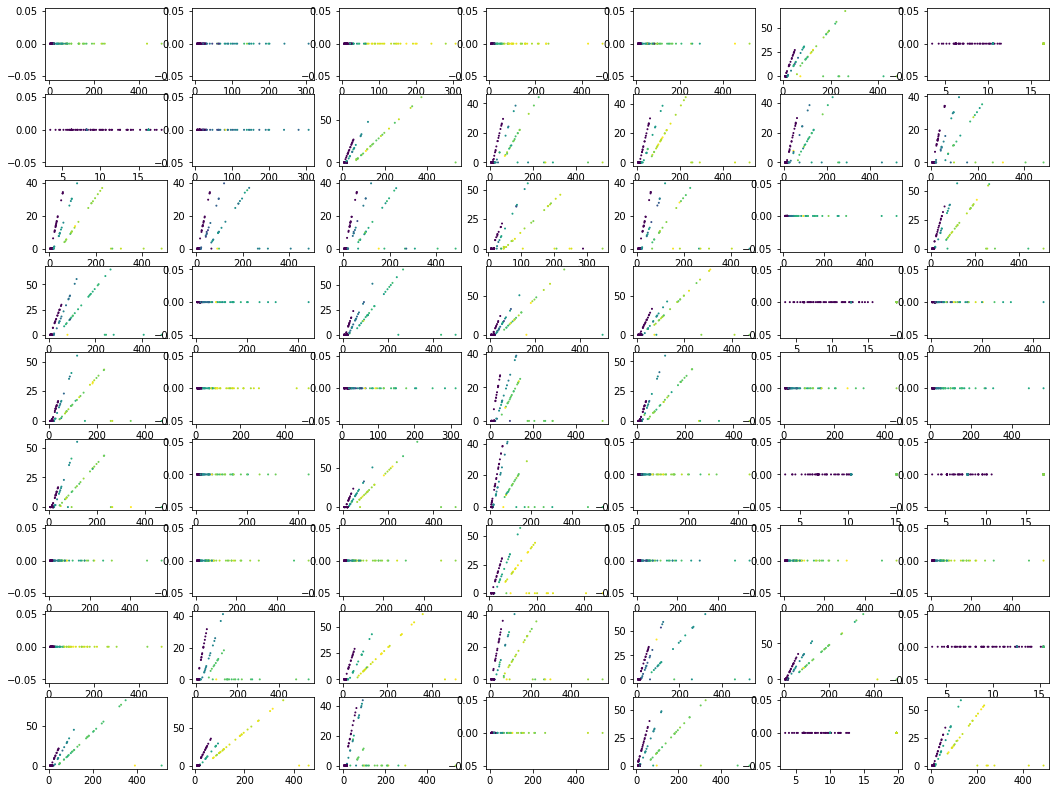

In [40]:
# plotting difference between two copayments against the higher copayment
fig, axs = plt.subplots(9, 7, figsize = (18, 14))
n = 0
for name, group in copayments_groups:
    axs[n // 7, n % 7].scatter(group['copayment_high'], group['copayment_high'] - group['copayment_low'], 
                               c = group['rejection_rate'], s = 1)
    #axs[n // 7, n % 7].set_xlim([0, 600])
    #axs[n // 7, n % 7].set_ylim([0, 100])
    n += 1

fig.show()

There are three categories of insurances can be identified:
* **Category 1** (23 insurances): one copayment for each drug on each plan with a large range of copayments, for example, ('322463', '9FU70', 'U19J4RVCA')
* **Category 2** (7 insurances): one copayment for each drug on each plan with a small range of copayments below 20, for example, ('322463', 'T52GV', 'EVD4X5')
* **Category 3** (33 insurances): two copayments for most of drugs with one copayment for some of the drugs, for example, ('539437', 'RAM3J', '7DUPMODV0')

<ipython-input-134-8d69206801ce>:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


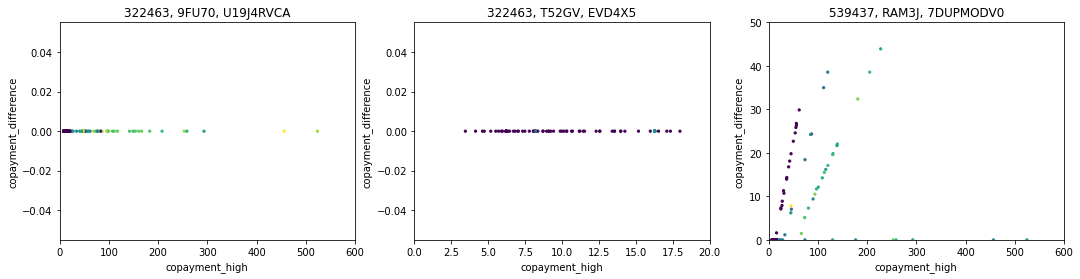

In [134]:
# plotting difference between two copayments against the higher copayment
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayments_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
axs[0].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], 
               c = sample['rejection_rate'], s = 5)
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_title('322463, 9FU70, U19J4RVCA')

# insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayments_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
axs[1].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], 
               c = sample['rejection_rate'], s = 5)
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 20])
axs[1].set_title('322463, T52GV, EVD4X5')

# insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayments_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
axs[2].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], 
               c = sample['rejection_rate'], s = 5)
axs[2].set_xlabel('copayment_high')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 50])
axs[2].set_title('539437, RAM3J, 7DUPMODV0')

fig.show()

In [42]:
# getting insurances for three categories
insurance1, insurance2, insurance3 = [], [], []
n = 0
for name, group in copayments_groups:
    if n in [0, 1, 2, 3, 4, 8, 19, 22, 27, 29, 30, 33, 34, 36, 39, 42, 43, 44, 46, 47, 48, 49, 59]:
        insurance1.append(name)
    elif n in [6, 7, 26, 40, 41, 55, 61]:
        insurance2.append(name)
    else:
        insurance3.append(name)
    n += 1

### 2.1. Formulary status for drugs on insurances in category 1

For the insurances in the category 1, rejection rate and copayment are used to cluster the drugs.

In [43]:
# getting insurances in category 1
copayment1 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance1])
copayment1_groups = copayment1.groupby(['bin', 'pcn', 'group'])

<ipython-input-141-2f14a6127615>:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


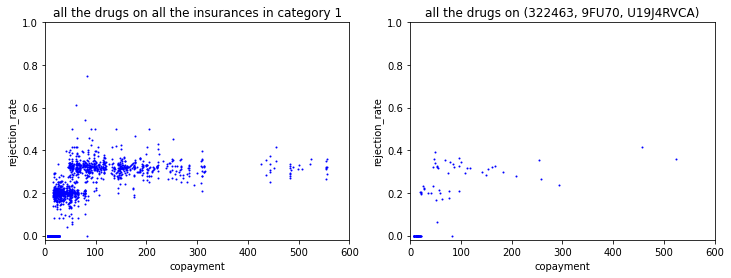

In [141]:
# plotting drugs on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
axs[0].scatter(copayment1['copayment_high'], copayment1['rejection_rate'], c = 'b', s = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-0.02, 1])
axs[0].set_title('all the drugs on all the insurances in category 1')

# all the drugs on insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayment1_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
axs[1].scatter(sample['copayment_high'], sample['rejection_rate'], c = 'b', s = 1)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-0.02, 1])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

fig.show()

Tier 1 is assigned to drugs with zero rejection rate.

<ipython-input-142-3036e8061cba>:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


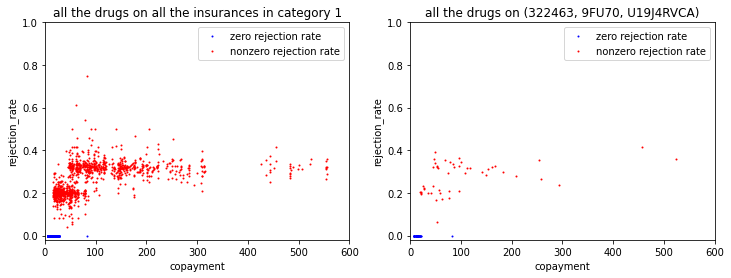

In [142]:
# plotting drugs on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
tier1 = copayment1[copayment1['rejection_rate'] == 0]
left = copayment1[copayment1['rejection_rate'] != 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1, label = 'nonzero rejection rate')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2])
axs[0].set_title('all the drugs on all the insurances in category 1')

# all the drugs on insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayment1_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, 
                      label = 'zero rejection rate')
plot2,  = axs[1].plot(sample_left['copayment_high'], sample_left['rejection_rate'], 'ro', ms = 1, 
                      label = 'nonzero rejection rate')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

fig.show()

Labels for three tiers of drugs with nonzero rejection rate are obtained from clustering with kmeans.

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<ipython-input-143-0ed87a23804e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
<ipython-input-143-0ed87a23804e>:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


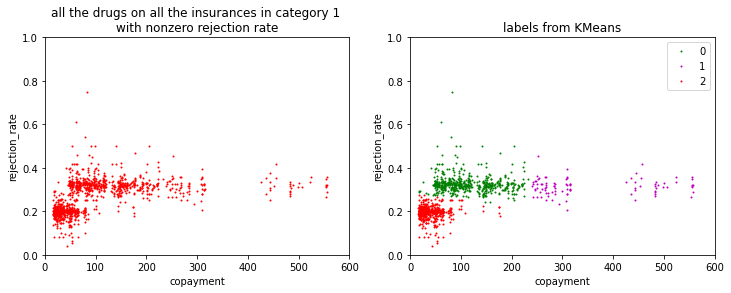

In [143]:
# plotting drugs with nonzero rejection rate on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 1])
axs[0].set_title('all the drugs on all the insurances in category 1 \nwith nonzero rejection rate')

# labels obtained from kmeans
pipe = Pipeline([('scaler', StandardScaler()), ('km', KMeans(n_clusters = 3, random_state = 614))])
left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
class1 = left[left['class'] == 0]
class2 = left[left['class'] == 1]
class3 = left[left['class'] == 2]
plot1,  = axs[1].plot(class1['copayment_high'], class1['rejection_rate'], 'go', ms = 1, label = 0)
plot2,  = axs[1].plot(class2['copayment_high'], class2['rejection_rate'], 'mo', ms = 1, label = 1)
plot3,  = axs[1].plot(class3['copayment_high'], class3['rejection_rate'], 'ro', ms = 1, label = 2)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 1])
axs[1].legend(handles = [plot1, plot2, plot3])
axs[1].set_title('labels from KMeans')

fig.show()

There are four tiers for drugs on insurances in category 1

<ipython-input-144-e7644f1f145e>:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


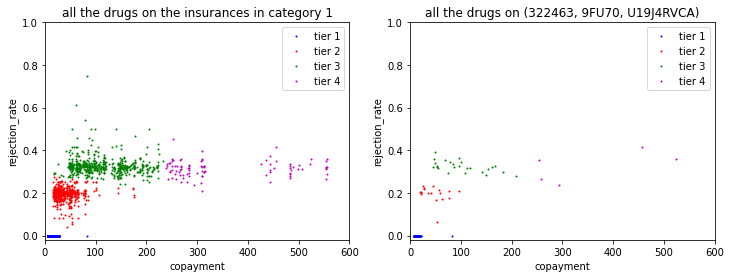

In [144]:
# plotting drugs on insurances in category 1 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
tier2 = left[left['class'] == 2]
tier3 = left[left['class'] == 0]
tier4 = left[left['class'] == 1]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[0].plot(tier2['copayment_high'], tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[0].plot(tier3['copayment_high'], tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
plot4,  = axs[0].plot(tier4['copayment_high'], tier4['rejection_rate'], 'mo', ms = 1, label = 'tier 4')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2, plot3, plot4])
axs[0].set_title('all the drugs on the insurances in category 1')

# all the drugs on insurance ('322463', '9FU70', 'U19J4RVCA')
left_groups = left.groupby(['bin', 'pcn', 'group'])
sample = left_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
sample_tier2 = sample[sample['class'] == 2]
sample_tier3 = sample[sample['class'] == 0]
sample_tier4 = sample[sample['class'] == 1]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[1].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[1].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
plot4,  = axs[1].plot(sample_tier4['copayment_high'], sample_tier4['rejection_rate'], 'mo', ms = 1, label = 'tier 4')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2, plot3, plot4])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

fig.show()

<ipython-input-145-fc6d3a0f9ee3>:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


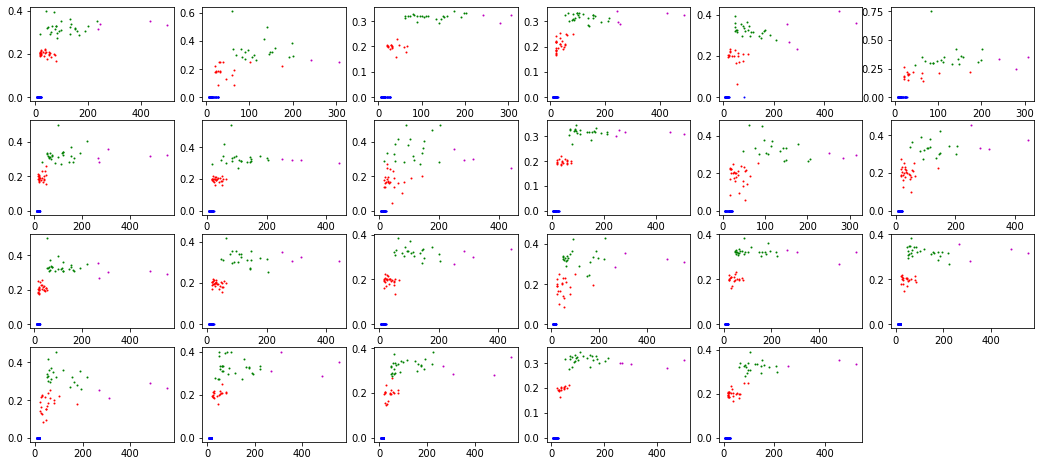

In [145]:
# clusters for all the drugs on each insurance in category 1
tier1_groups = tier1.groupby(['bin', 'pcn', 'group'])

fig, axs = plt.subplots(4, 6, figsize = (18, 8))
n = 0
for name, group in copayment1_groups:
    sample_tier1 = tier1_groups.get_group(name)
    sample_left = left_groups.get_group(name)
    sample_tier2 = sample_left[sample_left['class'] == 2]
    sample_tier3 = sample_left[sample_left['class'] == 0]
    sample_tier4 = sample_left[sample_left['class'] == 1]
    axs[n // 6, n % 6].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1)
    axs[n // 6, n % 6].plot(sample_tier4['copayment_high'], sample_tier4['rejection_rate'], 'mo', ms = 1)
    n += 1

axs[3, 5].set_axis_off()

fig.show()

### 2.2. Formulary status for drugs on insurances in category 2

For the insurances in the category 2, rejection rate and copayment are used to cluster the drugs.

In [163]:
# getting insurances in category 2
copayment2 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance2])
copayment2_groups = copayment2.groupby(['bin', 'pcn', 'group'])

7

<ipython-input-153-beeff520bf78>:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


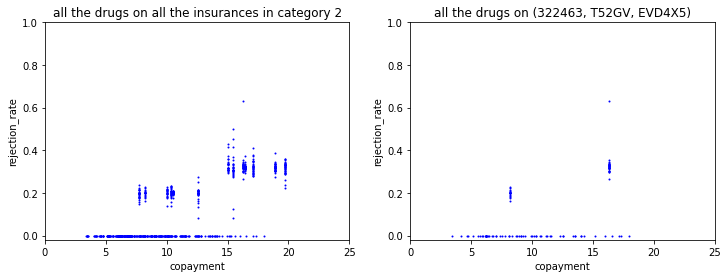

In [153]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 2
axs[0].scatter(copayment2['copayment_high'], copayment2['rejection_rate'], c = 'b', s = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([-0.02, 1])
axs[0].set_title('all the drugs on all the insurances in category 2')

# all the drugs on insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayment2_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
axs[1].scatter(sample['copayment_high'], sample['rejection_rate'], c = 'b', s = 1)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([-0.02, 1])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

fig.show()

Tier 1 is assigned to drugs with zero rejection rate.

<ipython-input-154-a9aba60387e7>:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


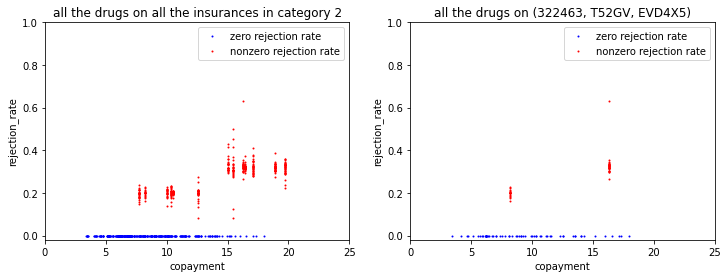

In [154]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 2
tier1 = copayment2[copayment2['rejection_rate'] == 0]
left = copayment2[copayment2['rejection_rate'] != 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1, label = 'nonzero rejection rate')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2])
axs[0].set_title('all the drugs on all the insurances in category 2')

# all the drugs on insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayment2_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, 
                      label = 'zero rejection rate')
plot2,  = axs[1].plot(sample_left['copayment_high'], sample_left['rejection_rate'], 'ro', ms = 1, 
                      label = 'nonzero rejection rate')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

fig.show()

Labels for three tiers of drugs with nonzero rejection rate are obtained from clustering with kmeans.

<ipython-input-155-55218ac92344>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
<ipython-input-155-55218ac92344>:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


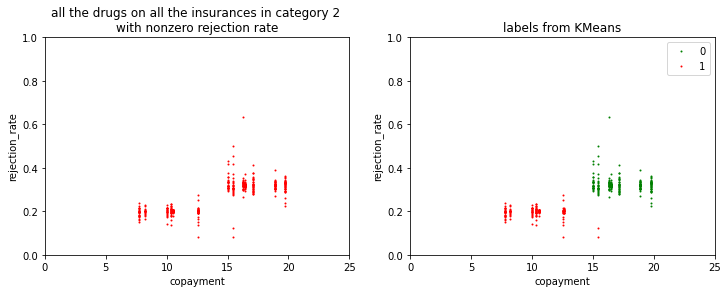

In [155]:
# plotting drugs with nonzero rejection rate on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([0, 1])
axs[0].set_title('all the drugs on all the insurances in category 2 \nwith nonzero rejection rate')

# labels obtained from kmeans
pipe = Pipeline([('scaler', StandardScaler()), ('km', KMeans(n_clusters = 2, random_state = 614))])
left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
class1 = left[left['class'] == 0]
class2 = left[left['class'] == 1]
plot1,  = axs[1].plot(class1['copayment_high'], class1['rejection_rate'], 'go', ms = 1, label = 0)
plot2,  = axs[1].plot(class2['copayment_high'], class2['rejection_rate'], 'ro', ms = 1, label = 1)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([0, 1])
axs[1].legend(handles = [plot1, plot2])
axs[1].set_title('labels from KMeans')

fig.show()

There are three tiers for drugs on insurances in category 2

<ipython-input-161-da249d5bb59c>:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


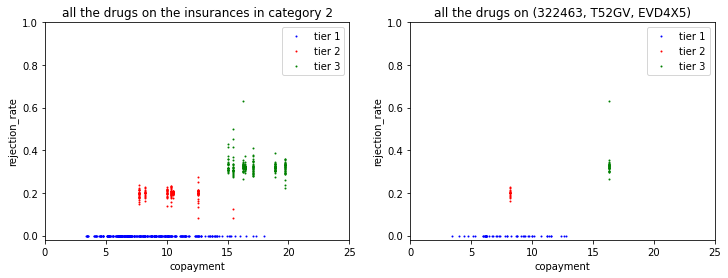

In [161]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
tier2 = left[left['class'] == 1]
tier3 = left[left['class'] == 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[0].plot(tier2['copayment_high'], tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[0].plot(tier3['copayment_high'], tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('rejection_rate')
axs[0].set_xlim([0, 25])
axs[0].set_ylim([-0.02, 1])
axs[0].legend(handles = [plot1, plot2, plot3])
axs[0].set_title('all the drugs on the insurances in category 2')

# all the drugs on insurance ('322463', 'T52GV', 'EVD4X5')
left_groups = left.groupby(['bin', 'pcn', 'group'])
sample = left_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
sample_tier2 = sample[sample['class'] == 1]
sample_tier3 = sample[sample['class'] == 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1, label = 'tier 1')
plot2,  = axs[1].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1, label = 'tier 2')
plot3,  = axs[1].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1, label = 'tier 3')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('rejection_rate')
axs[1].set_xlim([0, 25])
axs[1].set_ylim([-0.02, 1])
axs[1].legend(handles = [plot1, plot2, plot3])
axs[1].set_title('all the drugs on (322463, T52GV, EVD4X5)')

fig.show()

<ipython-input-183-096b10f5376e>:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


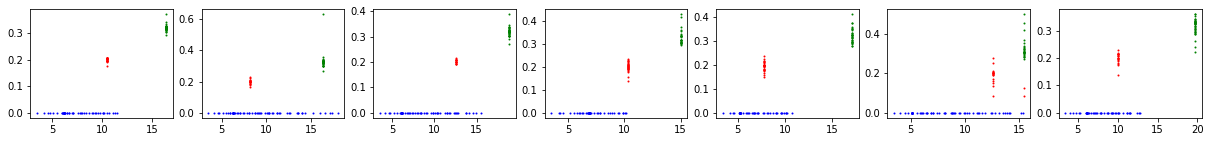

In [183]:
# clusters for all the drugs on each insurance in category 1
tier1_groups = tier1.groupby(['bin', 'pcn', 'group'])

fig, axs = plt.subplots(1, 7, figsize = (21, 2))
n = 0
for name, group in copayment2_groups:
    sample_tier1 = tier1_groups.get_group(name)
    sample_left = left_groups.get_group(name)
    sample_tier2 = sample_left[sample_left['class'] == 1]
    sample_tier3 = sample_left[sample_left['class'] == 0]
    axs[n % 7].plot(sample_tier1['copayment_high'], sample_tier1['rejection_rate'], 'bo', ms = 1)
    axs[n % 7].plot(sample_tier2['copayment_high'], sample_tier2['rejection_rate'], 'ro', ms = 1)
    axs[n % 7].plot(sample_tier3['copayment_high'], sample_tier3['rejection_rate'], 'go', ms = 1)
    n += 1

fig.show()

### 2.3. Formulary status for drugs on insurances in category 3

For the insurances in the category 3, difference between high and low copayment and high copayment are used to cluster the drugs, since the difference here is similar to the converage from the insurance.

In [173]:
# getting insurances in category 3
copayment3 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance3])
copayment3_groups = copayment3.groupby(['bin', 'pcn', 'group'])

<ipython-input-232-3c1a6848a457>:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


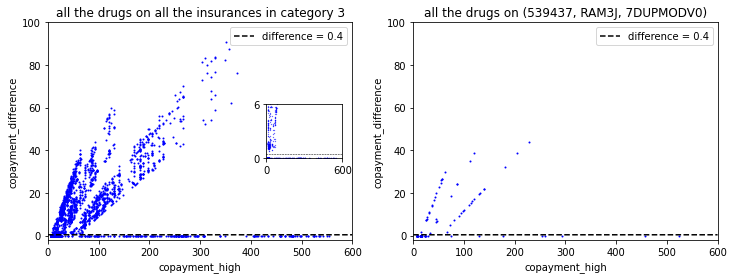

In [232]:
# plotting drugs on insurances in category 3 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 3
axs[0].scatter(copayment3['copayment_high'], copayment3['copayment_high'] - copayment3['copayment_low'], c = 'b', s = 1)
line,  = axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-2, 100])
axs[0].legend(handles = [line])
axs[0].set_title('all the drugs on all the insurances in category 3')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(copayment3['copayment_high'], copayment3['copayment_high'] - copayment3['copayment_low'], 'bo', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 6])
axins.set_xticks([0, 600])
axins.set_yticks([0, 6])

# all the drugs on insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayment3_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
axs[1].scatter(sample['copayment_high'], sample['copayment_high'] - sample['copayment_low'], c = 'b', s = 1)
line,  = axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[1].set_xlabel('copayment_high')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-2, 100])
axs[1].legend(handles = [line])
axs[1].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

Tier 1 is assigned to drugs with zero rejection rate.

<ipython-input-235-e89d1ad38826>:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


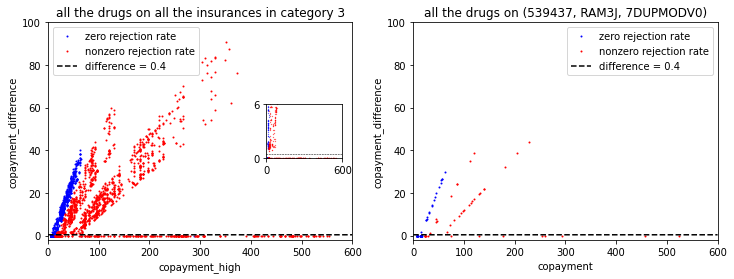

In [235]:
# plotting drugs on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 2
tier1 = copayment3[copayment3['rejection_rate'] == 0]
left = copayment3[copayment3['rejection_rate'] != 0]
plot1,  = axs[0].plot(tier1['copayment_high'], tier1['copayment_high'] - tier1['copayment_low'], 
                      'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[0].plot(left['copayment_high'], left['copayment_high'] - left['copayment_low'], 
                      'ro', ms = 1, label = 'nonzero rejection rate')
line,  = axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[0].set_xlabel('copayment_high')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-2, 100])
axs[0].legend(handles = [plot1, plot2, line])
axs[0].set_title('all the drugs on all the insurances in category 3')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(tier1['copayment_high'], tier1['copayment_high'] - tier1['copayment_low'], 'bo', ms = 0.25)
axins.plot(left['copayment_high'], left['copayment_high'] - left['copayment_low'], 'ro', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 6])
axins.set_xticks([0, 600])
axins.set_yticks([0, 6])

# all the drugs on insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayment3_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
sample_tier1 = sample[sample['rejection_rate'] == 0]
sample_left = sample[sample['rejection_rate'] != 0]
plot1,  = axs[1].plot(sample_tier1['copayment_high'], sample_tier1['copayment_high'] - sample_tier1['copayment_low'], 
                      'bo', ms = 1, label = 'zero rejection rate')
plot2,  = axs[1].plot(sample_left['copayment_high'], sample_left['copayment_high'] - sample_left['copayment_low'], 
                      'ro', ms = 1, label = 'nonzero rejection rate')
line,  = axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 0.4, 'k--', label = 'difference = 0.4')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-2, 100])
axs[1].legend(handles = [plot1, plot2, line])
axs[1].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

<ipython-input-207-c78ae621e515>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
<ipython-input-207-c78ae621e515>:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


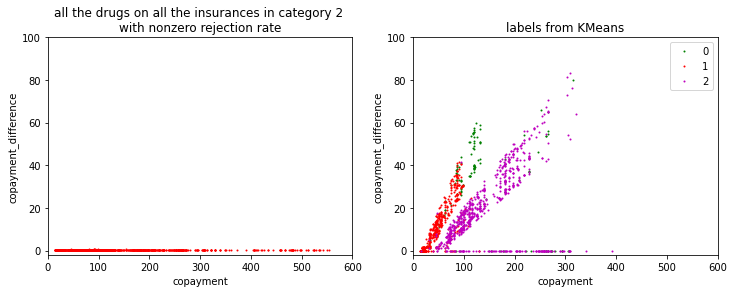

In [207]:
# plotting drugs with nonzero rejection rate on insurances in category 2 with respect to copayment and rejection rate
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

# all the drugs on insurances in category 1
axs[0].plot(left['copayment_high'], left['rejection_rate'], 'ro', ms = 1)
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([-2, 100])
axs[0].set_title('all the drugs on all the insurances in category 2 \nwith nonzero rejection rate')

# labels obtained from kmeans
#pipe = Pipeline([('scaler', StandardScaler()), ('km', KMeans(n_clusters = 3, random_state = 614))])
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('gm', GaussianMixture(n_components = 4, init_params = 'k-means++', covariance_type='tied', random_state = 614))])
#pipe = GaussianMixture(n_components = 3, init_params = 'k-means++', covariance_type='diag', random_state = 614)
left['class'] = pipe.fit_predict(left[['copayment_high', 'rejection_rate']])
class1 = left[left['class'] == 0]
class2 = left[left['class'] == 1]
class3 = left[left['class'] == 2]
plot1,  = axs[1].plot(class1['copayment_high'], class1['copayment_high'] - class1['copayment_low'], 'go', ms = 1, label = 0)
plot2,  = axs[1].plot(class2['copayment_high'], class2['copayment_high'] - class2['copayment_low'], 'ro', ms = 1, label = 1)
plot3,  = axs[1].plot(class3['copayment_high'], class3['copayment_high'] - class3['copayment_low'], 'mo', ms = 1, label = 2)
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([-2, 100])
axs[1].legend(handles = [plot1, plot2, plot3])
axs[1].set_title('labels from KMeans')

fig.show()

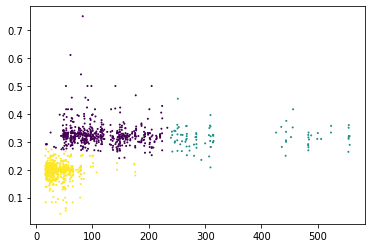

In [66]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#gm = GaussianMixture(n_components = 3, init_params = 'k-means++', random_state = 614)
#ms = MeanShift()
#sample = left[left['copayment_high'] < 400]
km = KMeans(n_clusters = 3, random_state = 614)
sample = left.copy()
scaler = StandardScaler()
#plt.plot(sample['copayment_high'] / max(sample['copayment_high']), sample['rejection_rate'], 'bo', ms = 1)
a = scaler.fit_transform(sample[['copayment_high', 'rejection_rate']])
sample['class'] = km.fit_predict(a)
plt.scatter(sample['copayment_high'], sample['rejection_rate'], c = sample['class'], s = 1)
#print(ax)
#b = a.reshape(2, -1)
#print(b)
#plt.plot(b[0], b[1], 'bo', ms = 1)
#sample['class'] = ms.fit_predict(b)
#plt.scatter(sample['copayment_high'], sample['rejection_rate'], color = sample['class'])
#sample['copayment_high'] = sample['copayment_high'] / 300
#sample['class'] = km.fit_predict(sample[['copayment_high', 'rejection_rate']])
#left['class'] = ms.fit_predict(left[['copayment_high', 'rejection_rate']])
#class1 = sample[sample['class'] == 0]
#class2 = sample[sample['class'] == 1]
#class3 = sample[sample['class'] == 2]
#plt.plot(class1['copayment_high'], class1['rejection_rate'], 'bo', ms = 1)
#plt.plot(class2['copayment_high'], class2['rejection_rate'], 'ro', ms = 1)
#plt.plot(class3['copayment_high'], class3['rejection_rate'], 'go', ms = 1)
plt.show()
plt.close()

The distributions of copayment for each drug on each insurance plan can be obtained from the data as well. There are two typical distributions throughout the data set. The first case with copayments is the copayment for the drug distributing over a small range, for example, branded debome on the insurance ('322463', '393U', 'XY5GQQ9'). The second case with copayments is there being two well concentrated clusters of copayments for the drug, for example, branded flacelfatastat on the insurance ('322463', 'YICC41', 'MP3IQ'). The third case with copayments is copayment being a flat rate, for example, branded bovirol on the insurance ('160389', 'RB7UU', 'RS5RB3YA').

In [12]:
# getting data for distribution
df_drug = df[['bin', 'pcn', 'group', 'drug', 'patient_pay']]
df_drug_groups = df_drug.groupby(['bin', 'pcn', 'group', 'drug'])

<ipython-input-13-dadcfa13236e>:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


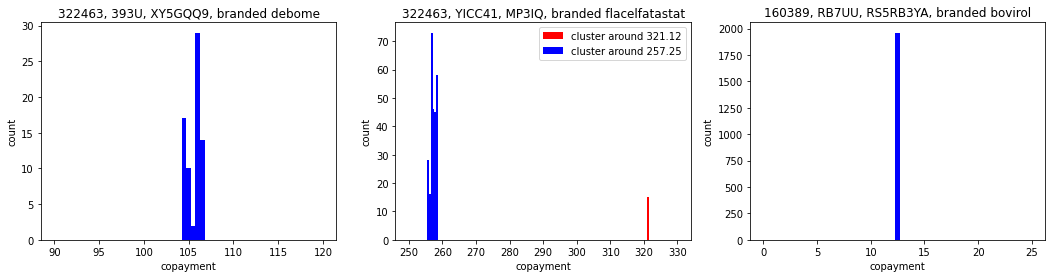

In [13]:
# plotting two typical distributions
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# copayment for branded debome on the insurance ('322463', '393U', 'XY5GQQ9') distributes over a small range of around 1.75
sample = df_drug_groups.get_group(('322463', '393U', 'XY5GQQ9', 'branded debome'))
bins = np.linspace(90, 120, 60)
axs[0].hist(sample['patient_pay'], bins, color = 'b')
axs[0].set_xlabel('copayment')
axs[0].set_ylabel('count')
axs[0].set_title('322463, 393U, XY5GQQ9, branded debome')

# branded flacelfatastat on the insurance ('322463', 'YICC41', 'MP3IQ') has two clusters of copayments
# one at around 321.12, the other at around 257.25
sample = df_drug_groups.get_group(('322463', 'YICC41', 'MP3IQ', 'branded flacelfatastat'))
sample_high = sample[sample['patient_pay'] > 290]
sample_low = sample[sample['patient_pay'] < 290]
bins = np.linspace(250, 330, 160)
axs[1].hist(sample_high['patient_pay'], bins, color = 'r')
axs[1].hist(sample_low['patient_pay'], bins, color = 'b')
axs[1].set_xlabel('copayment')
axs[1].set_ylabel('count')
axs[1].legend(['cluster around ' + str(321.12), 'cluster around ' + str(257.25)])
axs[1].set_title('322463, YICC41, MP3IQ, branded flacelfatastat')

# copayment for branded bovirol on the insurance ('160389', 'RB7UU', 'RS5RB3YA') only has one constant value of 12.54
sample = df_drug_groups.get_group(('160389', 'RB7UU', 'RS5RB3YA', 'branded bovirol'))
bins = np.linspace(0, 25, 50)
axs[2].hist(sample['patient_pay'], bins, color = 'b')
axs[2].set_xlabel('copayment')
axs[2].set_ylabel('count')
axs[2].set_title('160389, RB7UU, RS5RB3YA, branded bovirol')

fig.show()

For the first case, the copayment fluctuates within a small range. There is a natural interpretation for that which is the drug not covered by the insurance plan. So the patient always pays for the full cost of the drug which fluctuates a bit. For the second case, there is a natural interpretation as well. The drug itself is covered by the insurance. The cluster around higher copayment represents the full cost of the drug, and the cluster around lower copayment represents the partial cost after the deductible is meet. This is confirmed below with distinct copayment distributions over date for the two cases. For the first case, the copayment fluctuates within a small range throughout the whole year. For the second case, the cluster around higher copayment starts early before the deductible is meet and the cluster around lower copayment starts late and ends late after the deductible is meet.

<ipython-input-14-45053d37d581>:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


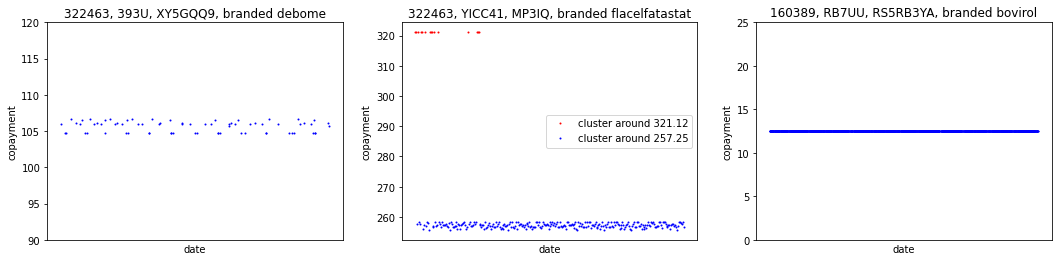

In [14]:
# comparison between two typical copayment distributions over date
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# copayment distribution over date for branded debome on the insurance ('322463', '393U', 'XY5GQQ9')
sample = df[['tx_date', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
sample_groups = sample.groupby(['bin', 'pcn', 'group', 'drug'])
sample = sample_groups.get_group(('322463', '393U', 'XY5GQQ9', 'branded debome'))
axs[0].plot(sample['patient_pay'], 'bo', ms = 1)
axs[0].set_xticks([])
axs[0].set_xlabel('date')
axs[0].set_ylabel('copayment')
axs[0].set_ylim([90, 120])
axs[0].set_title('322463, 393U, XY5GQQ9, branded debome')

# copayment distribution over date for branded flacelfatastat on the insurance ('322463', 'YICC41', 'MP3IQ')
sample = df[['tx_date', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
sample_groups = sample.groupby(['bin', 'pcn', 'group', 'drug'])
sample = sample_groups.get_group(('322463', 'YICC41', 'MP3IQ', 'branded flacelfatastat'))
sample_high = sample[sample['patient_pay'] > 290]
sample_low = sample[sample['patient_pay'] < 290]
sample_time = np.arange(len(sample))
axs[1].plot(sample_time[sample['patient_pay'] > 290], sample_high['patient_pay'], 'ro', ms = 1)
axs[1].plot(sample_time[sample['patient_pay'] < 290], sample_low['patient_pay'], 'bo', ms = 1)
axs[1].legend(['cluster around ' + str(321.12), 'cluster around ' + str(257.25)], loc = 'center right')
axs[1].set_xticks([])
axs[1].set_xlabel('date')
axs[1].set_ylabel('copayment')
axs[1].set_title('322463, YICC41, MP3IQ, branded flacelfatastat')

# copayment distribution over date for branded bovirol on the insurance ('160389', 'RB7UU', 'RS5RB3YA')
sample = df[['tx_date', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
sample_groups = sample.groupby(['bin', 'pcn', 'group', 'drug'])
sample = sample_groups.get_group(('160389', 'RB7UU', 'RS5RB3YA', 'branded bovirol'))
axs[2].plot(sample['patient_pay'], 'bo', ms = 1)
axs[2].set_xticks([])
axs[2].set_xlabel('date')
axs[2].set_ylabel('copayment')
axs[2].set_ylim([0, 25])
axs[2].set_title('160389, RB7UU, RS5RB3YA, branded bovirol')

fig.show()

For the distribution over pharmacy for the second case, it confirms the binary distribution is rather a result of coverage by the insurance plan after the deductible is meet than imbalanced distribution among pharmacies.

<ipython-input-15-02d8ada6483f>:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


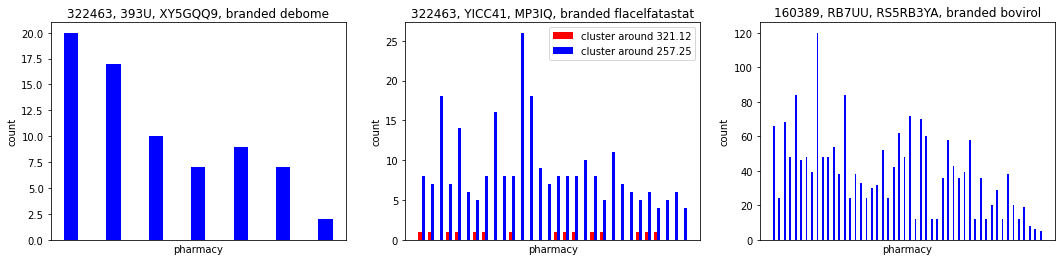

In [15]:
# copayment distribution over date and pharmacy for branded flacelfatastat on the insurance ('322463', 'YICC41', 'MP3IQ')
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# copayment distribution over pharmacy for branded debome on the insurance ('322463', '393U', 'XY5GQQ9')
sample = df[['pharmacy', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
sample_groups = sample.groupby(['bin', 'pcn', 'group', 'drug'])
sample = sample_groups.get_group(('322463', '393U', 'XY5GQQ9', 'branded debome'))[['pharmacy', 'patient_pay']]
sample_pharmacy = pd.unique(sample['pharmacy'])
sample_x = np.arange(len(pd.unique(sample['pharmacy']))) * 3
sample_height = [sum(sample['pharmacy'] == pharmacy) for pharmacy in sample_pharmacy]
axs[0].bar(sample_x, sample_height, width = 1, color = 'b')
axs[0].set_xticks([])
axs[0].set_xlabel('pharmacy')
axs[0].set_ylabel('count')
axs[0].set_title('322463, 393U, XY5GQQ9, branded debome')

# copayment distribution over pharmacy branded flacelfatastat on the insurance ('322463', 'YICC41', 'MP3IQ')
sample = df[['pharmacy', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
sample_groups = sample.groupby(['bin', 'pcn', 'group', 'drug'])
sample = sample_groups.get_group(('322463', 'YICC41', 'MP3IQ', 'branded flacelfatastat'))[['pharmacy', 'patient_pay']]
sample_pharmacy = pd.unique(sample['pharmacy'])
sample_x = np.arange(len(pd.unique(sample['pharmacy']))) * 3
sample_high = [sum((sample['pharmacy'] == pharmacy) & (sample['patient_pay'] > 290)) for pharmacy in sample_pharmacy]
sample_low = [sum((sample['pharmacy'] == pharmacy) & (sample['patient_pay'] < 290)) for pharmacy in sample_pharmacy]
axs[1].bar(sample_x, sample_high, width = 1, color = 'r')
axs[1].bar(sample_x + 1, sample_low, width = 1, color = 'b')
axs[1].set_xticks([])
axs[1].set_xlabel('pharmacy')
axs[1].set_ylabel('count')
axs[1].legend(['cluster around ' + str(321.12), 'cluster around ' + str(257.25)])
axs[1].set_title('322463, YICC41, MP3IQ, branded flacelfatastat')

# copayment distribution over pharmacy for branded bovirol on the insurance ('160389', 'RB7UU', 'RS5RB3YA')
sample = df[['pharmacy', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
sample_groups = sample.groupby(['bin', 'pcn', 'group', 'drug'])
sample = sample_groups.get_group(('160389', 'RB7UU', 'RS5RB3YA', 'branded bovirol'))[['pharmacy', 'patient_pay']]
sample_pharmacy = pd.unique(sample['pharmacy'])
sample_x = np.arange(len(pd.unique(sample['pharmacy']))) * 3
sample_height = [sum(sample['pharmacy'] == pharmacy) for pharmacy in sample_pharmacy]
axs[2].bar(sample_x, sample_height, width = 1, color = 'b')
axs[2].set_xticks([])
axs[2].set_xlabel('pharmacy')
axs[2].set_ylabel('count')
axs[2].set_title('160389, RB7UU, RS5RB3YA, branded bovirol')

fig.show()

As discussed above, whether a drug is covered by an insurance plan can be identified by whether there are two well concentrated clusters around two copayments, which can be achieved by fitting a Gaussian mixture model with two components for each drug on each insurance plan. If two well concentrated clusters are identified, the extracted means are the copayments and standard deviations are the fluctuations around the two copayments.

In [16]:
# import Gaussian mixture model
from sklearn.mixture import GaussianMixture

In [17]:
# fitting models and updating formulas
for name, group in df_drug_groups:
    try:
        gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
        gm.fit(group['patient_pay'].to_numpy().reshape(-1, 1))
        means = np.round(gm.means_.ravel(), 2)
        stds = np.round(np.sqrt(gm.covariances_.ravel()), 2)
        if means[0] > means[1]:
            formula.loc[name, 'copayment_before'] = means[0]
            formula.loc[name, 'std_before'] = stds[0]
            formula.loc[name, 'copayment_after'] = means[1]
            formula.loc[name, 'std_after'] = stds[1]
        else:
            formula.loc[name, 'copayment_before'] = means[1]
            formula.loc[name, 'std_before'] = stds[1]
            formula.loc[name, 'copayment_after'] = means[0]
            formula.loc[name, 'std_after'] = stds[0]
    except:
        formula.loc[name, 'copayment_before'] = group['patient_pay'].to_numpy()[0]
        formula.loc[name, 'std_before'] = 0
        formula.loc[name, 'copayment_after'] = formula.loc[name, 'copayment_before']
        formula.loc[name, 'std_after'] = 0

In [18]:
formula

rejection_rate  \
bin    pcn     group    drug                                      
160389 RB7UU   RS5RB3YA branded antimab                0.000000   
                        branded bovirol                0.000000   
                        branded brede                  0.208267   
                        branded choxestamenium         0.322488   
                        branded cibroniudosin          0.000000   
...                                                         ...   
96934  S76J7V6 NAN      generic tanoclolol             0.000000   
                        generic thiostasteglume        0.000000   
                        generic todiadianic            0.000000   
                        generic tovane                 0.000000   
                        generic vocopirin              0.000000   

                                                 copayment_before  std_before  \
bin    pcn     group    drug                                                    
160389 RB7UU   RS5RB3YA branded antimab                     21.61        0.35   
                        branded bovirol                     12.54        0.00   
                        branded brede                       19.42        0.41   
                        branded choxestamenium             132.72        0.48   
                        branded cibroniudosin               12.54        0.00   
...                                                           ...         ...   
96934  S76J7V6 NAN      generic tanoclolol                   6.17        0.00   
                        generic thiostasteglume             23.95        0.00   
                        generic todiadianic                 63.25        0.00   
                        generic tovane                       9.38        0.00   
                        generic vocopirin                   17.35        0.00   

                                                 copayment_after  std_after  
bin    pcn     group    drug                                                 
160389 RB7UU   RS5RB3YA branded antimab                    20.30       0.49  
                        branded bovirol                    12.54       0.00  
                        branded brede                      18.27       0.51  
                        branded choxestamenium            131.53       0.35  
                        branded cibroniudosin              12.54       0.00  
...                                                          ...        ...  
96934  S76J7V6 NAN      generic tanoclolol                  6.17       0.00  
                        generic thiostasteglume            15.57       0.74  
                        generic todiadianic                29.09       0.69  
                        generic tovane                      9.38       0.00  
                        generic vocopirin                  13.28       0.77  

[7087 rows x 5 columns]

In [19]:
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows', None)
formula[(formula['copayment_before'] == formula['copayment_after']) & (formula['rejection_rate'] != 0)]

rejection_rate  copayment_before  \
bin    pcn  group      drug                                                     
322463 393U XY5GQQ9    branded devacin             0.500000            140.70   
                       branded fumiluric           0.250000             29.65   
                       branded spifistime          0.083333             64.77   
                       generic fumiluric           0.083333             27.75   
       NAN  0TZ9XYJZJH branded gohevitravir        0.083333             17.04   
...                                                     ...               ...   
96934  9D24 VC81HUO7ZD branded vivafastat          0.336806             19.74   
                       branded vocopirin           0.195402             10.02   
                       generic hivir               0.215426             10.02   
                       generic sorine              0.201401             10.02   
                       generic todiadianic         0.216561             10.02   

                                             std_before  copayment_after  \
bin    pcn  group      drug                                                
322463 393U XY5GQQ9    branded devacin              0.0           140.70   
                       branded fumiluric            0.0            29.65   
                       branded spifistime           0.0            64.77   
                       generic fumiluric            0.0            27.75   
       NAN  0TZ9XYJZJH branded gohevitravir         0.0            17.04   
...                                                 ...              ...   
96934  9D24 VC81HUO7ZD branded vivafastat           0.0            19.74   
                       branded vocopirin            0.0            10.02   
                       generic hivir                0.0            10.02   
                       generic sorine               0.0            10.02   
                       generic todiadianic          0.0            10.02   

                                             std_after  
bin    pcn  group      drug                             
322463 393U XY5GQQ9    branded devacin             0.0  
                       branded fumiluric           0.0  
                       branded spifistime          0.0  
                       generic fumiluric           0.0  
       NAN  0TZ9XYJZJH branded gohevitravir        0.0  
...                                                ...  
96934  9D24 VC81HUO7ZD branded vivafastat          0.0  
                       branded vocopirin           0.0  
                       generic hivir               0.0  
                       generic sorine              0.0  
                       generic todiadianic         0.0  

[418 rows x 5 columns]

Now that the two copayments for each drug on each insurance plan have been identified, if two clusters are well concentrated around these two copayments, the higher copayment can be interpreted as the full cost of the drug before the deductile is meet and the difference between the two copayments can be interpreted as the coverage by the insurance after the deductible is meet. The copayment differences for all the drugs on each insurance plan are plotted against the higher copayments below.

In [20]:
# getting copayments
copayments = formula.copy().reset_index()
copayments_groups = copayments.groupby(['bin', 'pcn', 'group'])

<ipython-input-21-98de32bbfa40>:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


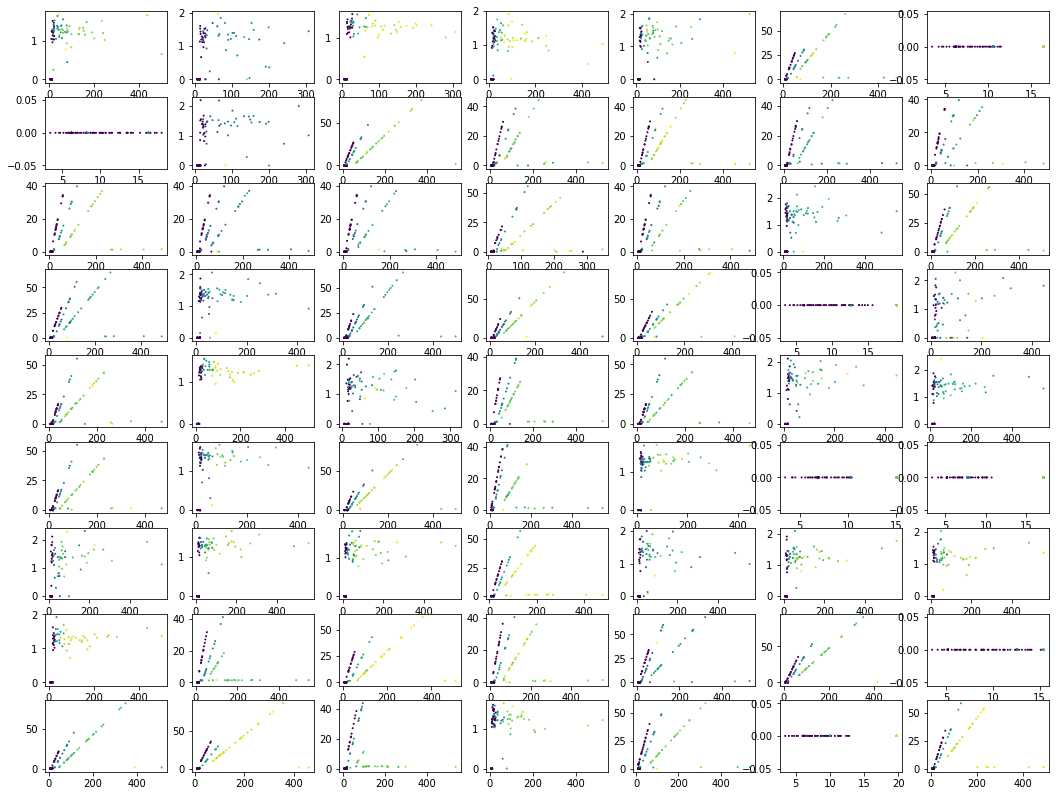

In [21]:
# plotting difference between two copayments against the higher copayment
fig, axs = plt.subplots(9, 7, figsize = (18, 14))
n = 0
for name, group in copayments_groups:
    axs[n // 7, n % 7].scatter(group['copayment_before'], group['copayment_before'] - group['copayment_after'], 
                               c = group['rejection_rate'], s = 1)
    #axs[n // 7, n % 7].set_xlim([0, 600])
    #axs[n // 7, n % 7].set_ylim([0, 100])
    n += 1

fig.show()

Three typical distributions of copayment difference over higher copayment for each insurance can be identified. The first one including 23 insurances, for example, ('322463', '9FU70', 'U19J4RVCA'), has really small copayment differences throughout the whole range of higher copayments. The second one including 33 insurances, for example, ('539437', 'RAM3J', '7DUPMODV0'), has three additional linear branches other than some small copayment differences. The third one including 7 insurances, for example, ('322463', 'T52GV', 'EVD4X5'), only have zero copayment difference which means the copayment is constant for all the drugs and the copayment is only below 20.

<ipython-input-22-e0965255bf6c>:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


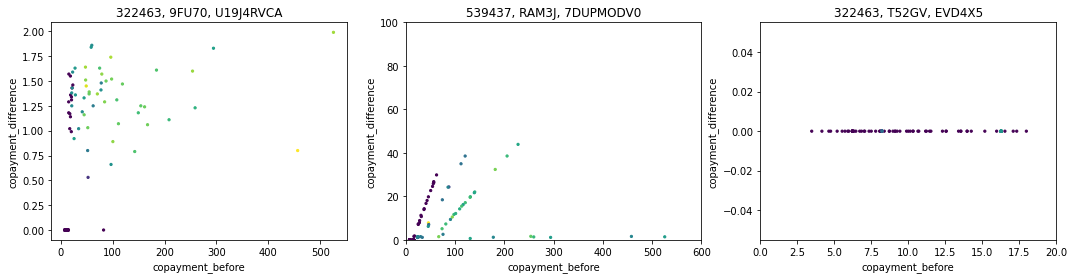

In [22]:
# plotting difference between two copayments against the higher copayment
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# insurance ('322463', '9FU70', 'U19J4RVCA')
sample = copayments_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
axs[0].scatter(sample['copayment_before'], sample['copayment_before'] - sample['copayment_after'], 
               c = sample['rejection_rate'], s = 5)
#axs[0].set_xlim([0, 600])
#axs[0].set_ylim([0, 3])
axs[0].set_xlabel('copayment_before')
axs[0].set_ylabel('copayment_difference')
axs[0].set_title('322463, 9FU70, U19J4RVCA')

# insurance ('539437', 'RAM3J', '7DUPMODV0')
sample = copayments_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
axs[1].scatter(sample['copayment_before'], sample['copayment_before'] - sample['copayment_after'], 
               c = sample['rejection_rate'], s = 5)
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 100])
axs[1].set_xlabel('copayment_before')
axs[1].set_ylabel('copayment_difference')
axs[1].set_title('539437, RAM3J, 7DUPMODV0')

# insurance ('322463', 'T52GV', 'EVD4X5')
sample = copayments_groups.get_group(('322463', 'T52GV', 'EVD4X5'))
axs[2].scatter(sample['copayment_before'], sample['copayment_before'] - sample['copayment_after'], 
               c = sample['rejection_rate'], s = 5)
axs[2].set_xlim([0, 20])
axs[2].set_xlabel('copayment_before')
axs[2].set_ylabel('copayment_difference')
axs[2].set_title('322463, T52GV, EVD4X5')

fig.show()

In [23]:
insurance1, insurance2, insurance3 = [], [], []
n = 0
for name, group in copayments_groups:
    if n in [0, 1, 2, 3, 4, 8, 19, 22, 27, 29, 30, 33, 34, 36, 39, 42, 43, 44, 46, 47, 48, 49, 59]:
        insurance1.append(name)
    elif n in [5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 28, 31, 32, 35, 37, 
               38, 45, 50, 51, 52, 53, 54, 56, 57, 58, 60, 62]:
        insurance2.append(name)
    else:
        insurance3.append(name)
    n += 1
print(insurance1)
print('\n')
print(insurance2)
print('\n')
print(insurance3)

[('160389', 'RB7UU', 'RS5RB3YA'), ('322463', '393U', 'XY5GQQ9'), ('322463', '3O71UTS', 'NAN'), ('322463', '3Y5ZW0', 'NAN'), ('322463', '9FU70', 'U19J4RVCA'), ('322463', 'ULM7G', 'NAN'), ('664344', 'AZUO5U', 'IGN6JL34H37D'), ('664344', 'DY4B', 'NAN'), ('664344', 'NAN', '77MAJF66DGD'), ('664344', 'NAN', 'STGRDKR1J5RD'), ('664344', 'NAN', 'TFZOR5R49'), ('664344', 'P4LC', 'O19XSLDEFB'), ('664344', 'REGLCC', 'BH2Q8B3GY2GAV'), ('664344', 'TAZ5W', 'T51T6V2E8L'), ('664344', 'YFVIA', 'AJK5MZ25T9IA'), ('691847', 'MQWH09H', '7Q756WMLLV25X'), ('691847', 'N098KI', '6SP1DG'), ('691847', 'NAN', 'I4UYEP84W3'), ('691847', 'NG4CS', 'GQIGYFQQ2WGH'), ('691847', 'XH4T3', 'GOM8K0'), ('691847', 'ZQPX', 'KZWQDIHCLLHD1'), ('718350', 'J5DT8', 'IX6P0'), ('757349', 'RM0HB', 'SJVO3GXUURRGO')]


[('322463', 'NAN', '0TZ9XYJZJH'), ('322463', 'YICC41', 'MP3IQ'), ('539437', 'CG3ZWQ', 'NAN'), ('539437', 'NAN', '1CAHL'), ('539437', 'RAM3J', '7DUPMODV0'), ('571569', 'FX2Z', 'OD99VAJGWV'), ('571569', 'KB38N', '6BYJBW'), ('

In [24]:
df1 = df[['pharmacy', 'bin', 'pcn', 'group', 'drug', 'patient_pay']]
df1_groups = df1.groupby(['bin', 'pcn', 'group', 'drug'])
df1_groups.get_group(('322463', '393U', 'XY5GQQ9', 'branded debome'))

,pharmacy,bin,pcn,group,drug,patient_pay
186138,Pharmacy #23,322463,393U,XY5GQQ9,branded debome,105.93
377974,Pharmacy #31,322463,393U,XY5GQQ9,branded debome,104.73
470535,Pharmacy #10,322463,393U,XY5GQQ9,branded debome,104.80
697191,Pharmacy #24,322463,393U,XY5GQQ9,branded debome,106.64
969531,Pharmacy #36,322463,393U,XY5GQQ9,branded debome,106.15
...,...,...,...,...,...,...
13057221,Pharmacy #44,322463,393U,XY5GQQ9,branded debome,106.51
13076610,Pharmacy #31,322463,393U,XY5GQQ9,branded debome,104.73
13107165,Pharmacy #10,322463,393U,XY5GQQ9,branded debome,104.80
13744315,Pharmacy #36,322463,393U,XY5GQQ9,branded debome,106.15


In [ ]:
sample[['pharmacy', 'patient_pay']]

(0.0, 20.0)

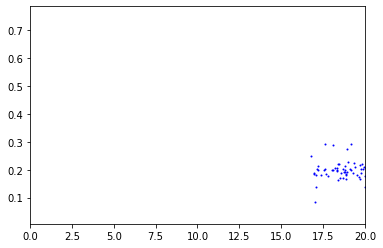

In [28]:
for insurance in insurance1:
    sample = copayments_groups.get_group(insurance)
    nonpreferred = sample[sample['rejection_rate'] != 0]
    plt.plot(nonpreferred['copayment_before'], nonpreferred['rejection_rate'], 'bo', ms = 1)
    #plt.plot(nonpreferred['copayment_before'], nonpreferred['rejection_rate'], 'bo', ms = 1)
plt.xlim([0, 20])

In [ ]:
copayment1 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance1])
copayment1_groups = copayment1.groupby(['bin', 'pcn', 'group'])

In [ ]:
tier1 = copayment1[copayment1['rejection_rate'] == 0]
nonpreferred = copayment1[copayment1['rejection_rate'] != 0]
plt.plot(tier1['copayment_before'], tier1['rejection_rate'], 'bo', ms = 1)
plt.plot(nonpreferred['copayment_before'], nonpreferred['rejection_rate'], 'ro', ms = 1)
plt.xlim([0, 600])
#sample = nonpreferred.loc[:, ['copayment_before', 'rejection_rate']]
#sample['pencentage'] = (nonpreferred['copayment_before'] - nonpreferred['copayment_after']) / nonpreferred['copayment_before']
#gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
#sample['class'] = gm.fit_predict(sample.loc[:, ['rejection_rate', 'pencentage']])
#class1 = sample[sample['class'] == 0]
#class2 = sample[sample['class'] == 1]
#class3 = sample[sample['class'] == 2]
#plt.plot(class1['rejection_rate'], class1['pencentage'], 'bo', ms = 1)
#plt.plot(class2['rejection_rate'], class2['pencentage'], 'ro', ms = 1)
#plt.plot(class3['pencentage'], class3['rejection_rate'], 'go', ms = 1)

In [ ]:
copayment2 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance2])
copayment2_groups = copayment2.groupby(['bin', 'pcn', 'group'])

In [ ]:
tier1 = copayment2[copayment2['rejection_rate'] == 0]
nonpreferred = copayment2[copayment2['rejection_rate'] != 0]
sample = nonpreferred.loc[:, ['copayment_before', 'rejection_rate']]
sample['copayment_difference'] = nonpreferred['copayment_before'] - nonpreferred['copayment_after']
low = sample[sample['rejection_rate'] < 0.05]
high = sample[sample['rejection_rate'] >= 0.05]
plt.plot(high['copayment_before'], high['copayment_difference'], 'ro', ms = 1)
plt.plot(low['copayment_before'], low['copayment_difference'], 'bo', ms = 1)
#plt.scatter(sample['copayment_before'], sample['copayment_difference'], c = sample['rejection_rate'], s = 2)
plt.xlim([0, 600])
plt.ylim([0, 6])
#gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
#sample['class'] = gm.fit_predict(sample.loc[:, ['copayment_difference', 'rejection_rate']])
#class1 = sample[sample['class'] == 0]
#class2 = sample[sample['class'] == 1]
#class3 = sample[sample['class'] == 2]
#plt.plot(class1['rejection_rate'], class1['copayment_difference'], 'bo', ms = 1)
#plt.plot(class2['rejection_rate'], class2['copayment_difference'], 'ro', ms = 1)
#plt.plot(class3['copayment_before'], class3['copayment_difference'], 'go', ms = 1)

In [26]:
copayment3 = pd.concat([copayments_groups.get_group(insurance) for insurance in insurance3])
copayment3_groups = copayment3.groupby(['bin', 'pcn', 'group'])

(0.0, 20.0)

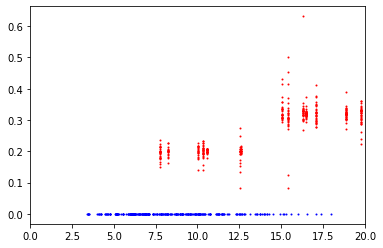

In [27]:
tier1 = copayment3[copayment3['rejection_rate'] == 0]
nonpreferred = copayment3[copayment3['rejection_rate'] != 0]
plt.plot(tier1['copayment_before'], tier1['rejection_rate'], 'bo', ms = 1)
plt.plot(nonpreferred['copayment_before'], nonpreferred['rejection_rate'], 'ro', ms = 1)
plt.xlim([0, 20])

In [ ]:
for insurance in insurance_cat2:
    sample = copayments_groups.get_group(insurance)
    #preferred = sample[sample['rejection_rate'] == 0]
    nonpreferred = sample[sample['rejection_rate'] != 0]
    #plt.plot(preferred['copayment_before'], preferred['copayment_before'] - preferred['copayment_after'], 'bo', ms = 1)
    plt.scatter(nonpreferred['copayment_before'], nonpreferred['copayment_before'] - nonpreferred['copayment_after'], 
                c = nonpreferred['rejection_rate'], s = 1)
plt.xlim([0, 600])
plt.ylim([0, 6])

In [ ]:
# plotting difference between two copayments against the higher copayments
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# all the drugs on all the insurances
axs[0].plot(copayments['copayment_before'], copayments['copayment_before'] - copayments['copayment_after'], 'bo', ms = 1)
line,  = axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--', label = 'difference = 3')
axs[0].set_xlabel('copayment_before')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 100])
axs[0].legend(handles = [line])
axs[0].set_title('all the drugs on all the insurances')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(copayments['copayment_before'], copayments['copayment_before'] - copayments['copayment_after'], 'bo', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 6])

# all the drugs on the insurance ('322463', '9FU70', 'U19J4RVCA')
sample1 = copayments_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
axs[1].plot(sample1['copayment_before'], sample1['copayment_before'] - sample1['copayment_after'], 'bo', ms = 1)
line,  = axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--', label = 'difference = 3')
axs[1].set_xlabel('copayment_before')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 100])
axs[1].legend(handles = [line])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

# all the drugs on the insurance ('539437', 'RAM3J', '7DUPMODV0')
sample2 = copayments_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
axs[2].plot(sample2['copayment_before'], sample2['copayment_before'] - sample2['copayment_after'], 'bo', ms = 1)
line,  = axs[2].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--', label = 'difference = 3')
axs[2].set_xlabel('copayment_before')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 100])
axs[2].legend(handles = [line])
axs[2].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

In the plot for all the drugs on all the insurances, there is a stripe of copayment differences lower than 3, which captures only the fluctuation in the full costs of drugs. Drugs that fall into this stripe are thus classified as non-covered. Further if considering whether rejection rate is zero or not, drugs with copayment differences larger than 3 can be classified as preferred (zero rejection rate) and non-preferred (non-zero rejection rate).

In [ ]:
# plotting difference between two copayments against the higher copayments
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# clusters for all the drugs on all the insurances
covered = copayments[copayments['copayment_before'] - copayments['copayment_after'] > 3]
preferred = covered[covered['rejection_rate'] == 0]
nonpreferred = covered[covered['rejection_rate'] != 0]
noncovered = copayments[copayments['copayment_before'] - copayments['copayment_after'] <= 3]
plot1,  = axs[0].plot(preferred['copayment_before'], preferred['copayment_before'] - preferred['copayment_after'], 
                      'bo', ms = 1, label = 'preferred')
plot2,  = axs[0].plot(nonpreferred['copayment_before'], nonpreferred['copayment_before'] - nonpreferred['copayment_after'], 
                      'ro', ms = 1, label = 'non-preferred')
plot3,  = axs[0].plot(noncovered['copayment_before'], noncovered['copayment_before'] - noncovered['copayment_after'], 
                      'go', ms = 1, label = 'non-covered')
axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--')
axs[0].set_xlabel('copayment_before')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 100])
axs[0].legend(handles = [plot1, plot2, plot3])
axs[0].set_title('all the drugs on all the insurances')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(preferred['copayment_before'], preferred['copayment_before'] - preferred['copayment_after'], 'bo', ms = 0.25)
axins.plot(nonpreferred['copayment_before'], nonpreferred['copayment_before'] - nonpreferred['copayment_after'], 
           'ro', ms = 0.25)
axins.plot(noncovered['copayment_before'], noncovered['copayment_before'] - noncovered['copayment_after'], 
           'go', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 6])
axins.set_xticks([0, 600])
axins.set_yticks([0, 6])

# clusters for all the drugs on the insurance ('322463', '9FU70', 'U19J4RVCA')
sample1 = copayments_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
plot,  = axs[1].plot(sample1['copayment_before'], sample1['copayment_before'] - sample1['copayment_after'], 
                     'go', ms = 1, label = 'non-covered')
axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--')
axs[1].set_xlabel('copayment_before')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 100])
axs[1].legend(handles = [plot])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

# clusters for all the drugs on the insurance ('539437', 'RAM3J', '7DUPMODV0')
sample2 = copayments_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
covered = sample2[sample2['copayment_before'] - sample2['copayment_after'] > 3]
preferred = covered[covered['rejection_rate'] == 0]
nonpreferred = covered[covered['rejection_rate'] != 0]
noncovered = sample2[sample2['copayment_before'] - sample2['copayment_after'] <= 3]
plot1,  = axs[2].plot(preferred['copayment_before'], preferred['copayment_before'] - preferred['copayment_after'], 
                      'bo', ms = 1, label = 'preferred')
plot2,  = axs[2].plot(nonpreferred['copayment_before'], nonpreferred['copayment_before'] - nonpreferred['copayment_after'], 
                      'ro', ms = 1, label = 'non-preferred')
plot3,  = axs[2].plot(noncovered['copayment_before'], noncovered['copayment_before'] - noncovered['copayment_after'], 
                      'go', ms = 1, label = 'non-covered')
axs[2].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--')
axs[2].set_xlabel('copayment_before')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 100])
axs[2].legend(handles = [plot1, plot2, plot3])
axs[2].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

For the insurance ('322463', '9FU70', 'U19J4RVCA'), it only has non-covered drugs. For the insurance (539437, RAM3J, 7DUPMODV0), it has preferred drugs, non-preferred drugs and non-covered drugs. For the covered drugs on the insurance (539437, RAM3J, 7DUPMODV0), the preferred drugs form the linear branch with the largest slop of the three. The higher copayment before the deductible is meet can be interpreted as the full cost of the drug. So the slope here can be interpreted as the percentage of the eligible cost covered by the insurance. By eligible cost it means there is a minimum cost above which the insurance only covers should there be any intercept with the copayment_before axis. The preferred drugs natually has more percentage of eligible cost covered and a lower minimum cost than the non-preferred drugs. Non-preferred drugs can be further divided into two groups by fitting a Gaussian mixture model with two components. The linear decision boundary can then be obtained by fitting a linear SVM classifier.

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
# dividing non-preferred drugs into two subgroups
fig, axs = fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# getting non-preferred drugs
covered = copayments[copayments['copayment_before'] - copayments['copayment_after'] > 3]
nonpreferred = covered[covered['rejection_rate'] != 0]
sample = nonpreferred.loc[:, ['copayment_before']]
sample['copayment_difference'] = nonpreferred['copayment_before'] - nonpreferred['copayment_after']
axs[0].plot(sample['copayment_before'], sample['copayment_difference'], 'ro', ms = 1)
axs[0].set_xlabel('copayment_before')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 100])
axs[0].set_title('all the non-preferred drugs on all the insurances')

# getting labels from Gaussian mixture model
gm = GaussianMixture(n_components = 2, init_params = 'k-means++', random_state = 614)
sample['class'] = gm.fit_predict(sample)
class1 = sample[sample['class'] == 1]
class2 = sample[sample['class'] == 0]
axs[1].plot(class1['copayment_before'], class1['copayment_difference'], 'ro', ms = 1)
axs[1].plot(class2['copayment_before'], class2['copayment_difference'], 'yo', ms = 1)
axs[1].set_xlabel('copayment_before')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 100])
axs[1].set_title('labels obtained from the Gaussian mixture model')

# getting linear boundary from linear SVM classifier
svc = LinearSVC(max_iter = 1000000)
svc.fit(sample[['copayment_before', 'copayment_difference']], sample['class'])
slop = round(-svc.coef_[0][0] / svc.coef_[0][1], 4)
intcpt = -round(svc.intercept_[0] / svc.coef_[0][1], 4)
line,  = axs[2].plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--', 
                     label = 'y = ' + str(slop) + '* x -' + str(abs(intcpt)))
axs[2].plot(class1['copayment_before'], class1['copayment_difference'], 'ro', ms = 1)
axs[2].plot(class2['copayment_before'], class2['copayment_difference'], 'yo', ms = 1)
axs[2].set_xlabel('copayment_before')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 100])
axs[2].legend(handles = [line])
axs[2].set_title('linear boundary obtained from the linear SVM classifier')

fig.show()

The linear boundary obtained above can be interpreted as 37.91% of the cost above 35.57 is covered by the insurance. Now all the drugs can be divided into four groups:
* tier 1: preferred (copayment difference larger than 3 and zero rejection rate)
* tier 2: non-prefered (copayment difference larger than 3, non-zero rejection rate and to the left of the linear boundary above)
* tier 3: non-prefered (copayment difference larger than 3, non-zero rejection rate and to the right of the linear boundary above)
* tier 4: non-covered (copayment difference smaller than or equal to 3)

In [ ]:
# plotting difference between two copayments against the higher copayments
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

# clusters for all the drugs on all the insurances
covered = copayments[copayments['copayment_before'] - copayments['copayment_after'] > 3]
tier1 = covered[covered['rejection_rate'] == 0]
nonpreferred = covered[covered['rejection_rate'] != 0]
tier2 = nonpreferred[nonpreferred['copayment_after'] - 0.6209 * nonpreferred['copayment_before'] < 13.4864]
tier3 = nonpreferred[nonpreferred['copayment_after'] - 0.6209 * nonpreferred['copayment_before'] >= 13.4864]
tier4 = copayments[copayments['copayment_before'] - copayments['copayment_after'] <= 3]
plot1,  = axs[0].plot(tier1['copayment_before'], tier1['copayment_before'] - tier1['copayment_after'], 
                      'bo', ms = 1, label = 'tier 1')
plot2,  = axs[0].plot(tier2['copayment_before'], tier2['copayment_before'] - tier2['copayment_after'], 
                      'ro', ms = 1, label = 'tier 2')
plot3,  = axs[0].plot(tier3['copayment_before'], tier3['copayment_before'] - tier3['copayment_after'], 
                      'yo', ms = 1, label = 'tier 3')
plot4,  = axs[0].plot(tier4['copayment_before'], tier4['copayment_before'] - tier4['copayment_after'], 
                      'go', ms = 1, label = 'tier 4')
axs[0].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--')
axs[0].plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--')
axs[0].set_xlabel('copayment_before')
axs[0].set_ylabel('copayment_difference')
axs[0].set_xlim([0, 600])
axs[0].set_ylim([0, 100])
axs[0].legend(handles = [plot1, plot2, plot3, plot4])
axs[0].set_title('all the drugs on all the insurances')
axins = inset_axes(axs[0], width = '25%', height = '25%', loc = 'center right', borderpad = 1)
axins.plot(tier1['copayment_before'], tier1['copayment_before'] - tier1['copayment_after'], 'bo', ms = 0.25)
axins.plot(tier2['copayment_before'], tier2['copayment_before'] - tier2['copayment_after'], 'ro', ms = 0.25)
axins.plot(tier3['copayment_before'], tier3['copayment_before'] - tier3['copayment_after'], 'yo', ms = 0.25)
axins.plot(tier4['copayment_before'], tier4['copayment_before'] - tier4['copayment_after'], 'go', ms = 0.25)
axins.plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--', linewidth = 0.5)
axins.plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--', linewidth = 0.5)
axins.set_xlim([0, 600])
axins.set_ylim([0, 6])
axins.set_xticks([0, 600])
axins.set_yticks([0, 6])

# clusters for all the drugs on the insurance ('322463', '9FU70', 'U19J4RVCA')
sample1 = copayments_groups.get_group(('322463', '9FU70', 'U19J4RVCA'))
plot,  = axs[1].plot(sample1['copayment_before'], sample1['copayment_before'] - sample1['copayment_after'], 
                     'go', ms = 1, label = 'tier 4')
axs[1].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--')
axs[1].set_xlabel('copayment_before')
axs[1].set_ylabel('copayment_difference')
axs[1].set_xlim([0, 600])
axs[1].set_ylim([0, 100])
axs[1].legend(handles = [plot])
axs[1].set_title('all the drugs on (322463, 9FU70, U19J4RVCA)')

# clusters for all the drugs on the insurance ('539437', 'RAM3J', '7DUPMODV0')
sample2 = copayments_groups.get_group(('539437', 'RAM3J', '7DUPMODV0'))
covered = sample2[sample2['copayment_before'] - sample2['copayment_after'] > 3]
tier1 = covered[covered['rejection_rate'] == 0]
nonpreferred = covered[covered['rejection_rate'] != 0]
tier2 = nonpreferred[nonpreferred['copayment_after'] - 0.6209 * nonpreferred['copayment_before'] < 13.4864]
tier3 = nonpreferred[nonpreferred['copayment_after'] - 0.6209 * nonpreferred['copayment_before'] >= 13.4864]
tier4 = sample2[sample2['copayment_before'] - sample2['copayment_after'] <= 3]
plot1,  = axs[2].plot(tier1['copayment_before'], tier1['copayment_before'] - tier1['copayment_after'], 
                      'bo', ms = 1, label = 'tier 1')
plot2,  = axs[2].plot(tier2['copayment_before'], tier2['copayment_before'] - tier2['copayment_after'], 
                      'ro', ms = 1, label = 'tier 2')
plot3,  = axs[2].plot(tier3['copayment_before'], tier3['copayment_before'] - tier3['copayment_after'], 
                      'yo', ms = 1, label = 'tier 3')
plot4,  = axs[2].plot(tier4['copayment_before'], tier4['copayment_before'] - tier4['copayment_after'], 
                      'go', ms = 1, label = 'tier 4')
axs[2].plot(np.linspace(0, 600, 6000), np.ones(6000) * 3, 'k--')
axs[2].plot(np.linspace(0, 400, 4000), slop * np.linspace(0, 400, 4000) + intcpt, 'k--')
axs[2].set_xlabel('copayment_before')
axs[2].set_ylabel('copayment_difference')
axs[2].set_xlim([0, 600])
axs[2].set_ylim([0, 100])
axs[2].legend(handles = [plot1, plot2, plot3, plot4])
axs[2].set_title('all the drugs on (539437, RAM3J, 7DUPMODV0)')

fig.show()

These findings can be observed in all the insurances

In [ ]:
# clustering all the drugs on each insurance
fig, axs = plt.subplots(9, 7, figsize = (18, 14))
n = 0
for name, group in copayments_groups:
    if max(group['copayment_before'] - group['copayment_after']) <= 3:
        axs[n // 7, n % 7].plot(group['copayment_before'], group['copayment_before'] - group['copayment_after'], 'go', ms = 1)
    else:
        covered = group[group['copayment_before'] - group['copayment_after'] > 3]
        tier1 = covered[covered['rejection_rate'] == 0]
        nonpreferred = covered[covered['rejection_rate'] != 0]
        tier2 = nonpreferred[nonpreferred['copayment_after'] - 0.6209 * nonpreferred['copayment_before'] < 13.4864]
        tier3 = nonpreferred[nonpreferred['copayment_after'] - 0.6209 * nonpreferred['copayment_before'] >= 13.4864]
        tier4 = group[group['copayment_before'] - group['copayment_after'] <= 3]
        axs[n // 7, n % 7].plot(tier1['copayment_before'], tier1['copayment_before'] - tier1['copayment_after'], 'bo', ms = 1)
        axs[n // 7, n % 7].plot(tier2['copayment_before'], tier2['copayment_before'] - tier2['copayment_after'], 'ro', ms = 1)
        axs[n // 7, n % 7].plot(tier3['copayment_before'], tier3['copayment_before'] - tier3['copayment_after'], 'yo', ms = 1)
        axs[n // 7, n % 7].plot(tier4['copayment_before'], tier4['copayment_before'] - tier4['copayment_after'], 'go', ms = 1)
    axs[n // 7, n % 7].set_xlim([0, 600])
    axs[n // 7, n % 7].set_ylim([0, 100])
    n += 1

fig.show()

Now that all the drugs are clustered on all the insurances, the formula can be updated accordingly. For the drugs that are classified as non-covered, a Gaussian mixture model with one component is fitted to extract the mean, which is assigned to both the copayments before and after the deductible is meet, and the standard deviation, which is assigned to both the standard deviations before and after the deductible is meet.

In [ ]:
# fitting models and updating formulas
for name, group in df_drug_groups:
    if formula.loc[name, 'copayment_before'] - formula.loc[name, 'copayment_after'] <= 3:
        try:
            gm = GaussianMixture(n_components = 1, init_params = 'k-means++', random_state = 614)
            gm.fit(group['patient_pay'].to_numpy().reshape(-1, 1))
            formula.loc[name, 'copayment_before'] = np.round(gm.means_.ravel(), 2)[0]
            formula.loc[name, 'std_before'] = np.round(np.sqrt(gm.covariances_.ravel()), 2)[0]
        except:
            formula.loc[name, 'copayment_before'] = group['patient_pay'].to_numpy()[0]
            formula.loc[name, 'std_before'] = 0
        formula.loc[name, 'copayment_after'] = formula.loc[name, 'copayment_before']
        formula.loc[name, 'std_after'] = formula.loc[name, 'std_before']
        formula.loc[name, 'formulary_status'] = 'tier 4'
    else:
        if formula.loc[name, 'rejection_rate'] == 0:
            formula.loc[name, 'formulary_status'] = 'tier 1'
        else:
            if formula.loc[name, 'copayment_after'] - 0.6209 * formula.loc[name, 'copayment_before'] < 13.4864:
                formula.loc[name, 'formulary_status'] = 'tier 2'
            else:
                formula.loc[name, 'formulary_status'] = 'tier 3'

formula['full_cost'] = formula['copayment_before'].astype(str).str.cat(formula['std_before'].astype(str), sep = ' +/- ')
formula['copayment'] = formula['copayment_after'].astype(str).str.cat(formula['std_after'].astype(str), sep = ' +/- ')
formula = formula.drop(columns = ['copayment_before', 'std_before', 'copayment_after', 'std_after'])
formula = formula.reindex(columns = ['rejection_rate', 'full_cost', 'copayment', 'formulary_status'])

In [ ]:
formula